In [15]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from f3 import photometry

Define a target through its KIC identifier. Here, I use KIC 8462852 as an example. ffi_dir is an optional argument
if your FFIs are stored anywhere other than a subdirectory from your working directory called "ffidata"

In [3]:
target = photmetry.star(8462852, ffi_dir='../kepler_ffis/')

In [6]:
target.make_postcard()

The step above takes all the FFIs and locates a small region centered on the target. It takes three optional arguments. npix is the size of the square postcard region. shape=(1070,1132) is the size of the FFIs, which can be changed if you're adapting the code to something other than Kepler FFIs (such as TESS data). buffer_size avoids the outermost pixels on the detector, so that each target should have its entire PSF on the detector.

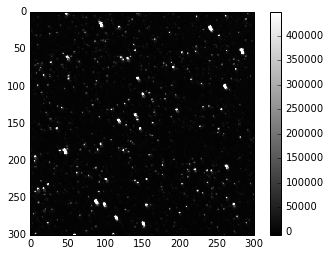

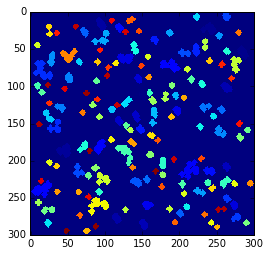

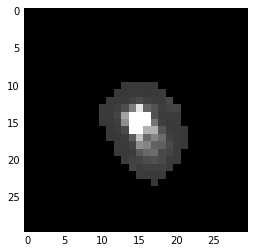

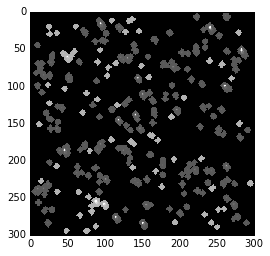

In [17]:
target.find_other_sources(plot_flag=True)

This step will draw apertures around the target star and up to ntargets additional targets on the same postcard.
It will then remove apertures that touch the border of the postcard and combine apertures that touch into one target,
treating those stars as a single object for the rest of the procedure.

The "plot_flag" argument will show a stacked plot of the postcard images, then a plot of all apertures for all targets, then a plot of the default aperture for the primary target, and finally data for the entire postcard, with apertures for all targets highlighted over the data.

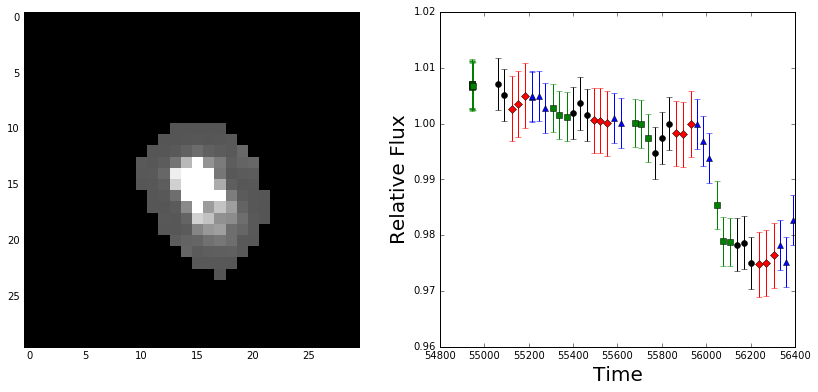

In [18]:
target.adjust_aperture()

Perhaps the initial aperture isn't appropriate, because it contians another star or doesn't capture the entire PSF, for example. This routine will enable you to change the aperture for the target star. It will open up a window showing the aperture (and underlying data) and the current light curve for the target star. By clicking on individual pixels, you can include or exclude them from the aperture. Closing the panel will then cause the photometry pipeline to re-run, and you can see how the light curve has changed from including/excluding those pixels. This will repeat until the image is closed without any changes to the aperture.

Clicking on the zeroth row/column (on the top or left) will cause all pixels in that column/row (respectively) to be turned off.

Re-running find_other_sources will restart this procedure, giving you back the default aperture.

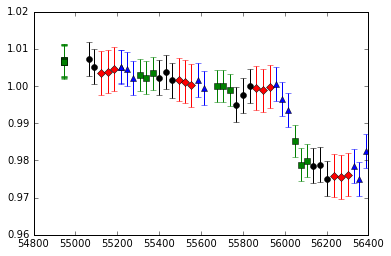

In [16]:
fmt = ['ko', 'rD', 'b^', 'gs']

for i in xrange(4):
    g = np.where(target.qs == i)[0]
    plt.errorbar(target.times[g], target.obs_flux[g], yerr=target.flux_uncert[i], fmt=fmt[i])

The error bars are overestimated in this case---they represent the residuals to a linear fit to the data, which is clearly inappropriate for this star. The colors/shapes represent different orientations of the spacecraft as it rotates to keep its solar panels aligned with the Sun.

In [19]:
target.data_for_target()

This calculates photometry without the aperture varying step, just using whatever aperture is currently defined (where target.targets == 1). target.targets == 0 is the background, and all other integers correspond to different targets.

In [20]:
target.calc_centroids()

Measures the centroid shift.

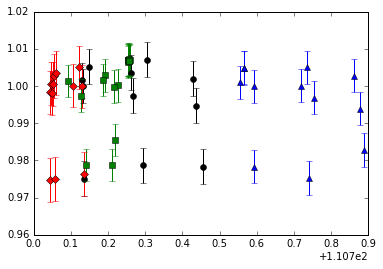

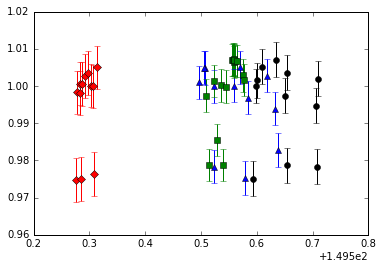

In [26]:
for i in xrange(4):
    g = np.where(target.qs == i)[0]
    plt.errorbar(target.cm[g,0], target.obs_flux[g], yerr=target.flux_uncert[i], fmt=fmt[i])
    
plt.show()
    
for i in xrange(4):
    g = np.where(target.qs == i)[0]
    plt.errorbar(target.cm[g,1], target.obs_flux[g], yerr=target.flux_uncert[i], fmt=fmt[i])

No obvious correlation with the large dimming here!

In [27]:
target.define_spotsignal()

This roughly estimates with the flux "should" be at the FFI times based on the starspot signal at the last observation before the FFIs by computing the flux at that last observation (1 hour before the FFI) relative to the median flux in that quarter of observations. Useful for making sure you're not being confused with aliasing.

We then can use the kepcal routine of Dan Foreman-Mackey to build a GP model for the flux of the star in time. (https://github.com/dfm/kepcal). This code will take in target.photometry_array in this case.